In [1]:
import requests
import json
import re
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [5]:
API_KEY = 'RGAPI-3634aa74-eca4-410b-be88-5f4009f607b3'
FEATURED_GAMES_URL = f'https://na1.api.riotgames.com/lol/spectator/v4/featured-games?api_key={API_KEY}'
SUMMONER_INFO_URL = 'https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/'
MATCH_ID_URL = 'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/'
MATCH_INFO_URL = 'https://americas.api.riotgames.com/lol/match/v5/matches/'

In [3]:
# # getting a list of currently featured games
# games_req = requests.get(FEATURED_GAMES_URL).text
# all_games = json.loads(games_req)

# # gathering names of all players in each featured game
# players = []
# for game in all_games['gameList']:
#     for particpant in game['participants']:
#         players.append(particpant['summonerName'])

# # gathering the encrypted puuids of each summoner and then finding the match_ids of their first 20 recent matches.
# match_ids = []
# for player in players:
#     url = f'{SUMMONER_INFO_URL}{players}?api_key={API_KEY}'
#     player_req = requests.get(url).text
#     player_info = json.loads(player_req)

#     COUNT = 20
#     url = f'{MATCH_ID_URL}{player_info["puuid"]}/ids?start=0&count={COUNT}&api_key={API_KEY}'
#     match_ids_req = requests.get(url).text
#     matches = json.loads(match_ids_req)

#     match_ids += matches


The code above goes through the process of accessing and collecting the data directly from Riot's APIs. In order to get a large amount of random data, we first used one of Riots API endpoints to get a list of featured games that have been played recently. The API request returns a large string that can be then parsed into a JSON object. Within the object is a `gameList` field which provides a list of the featured games. Within the `gameList` list, a `participants` field can be accessed which gives a list of participant usernames for a particular game in the list.

Using the `gameList`, all of the participants in each game can be stored within the `players` list. Since the featured games API endpoint only provides a small amount of games, we can instead use the recently played matches for each of the participants we stored allowing us to access many more matches that we could not get before.

Going through each player in the `players` list, we then need to call another API endpoint using each player's username. The way Riot's API works is that it is not possible to access individual player data through their username alone. Riot instead provides an option to acquire the PUUID, a universally unique identifer, that can then be used to access more information about each player. So, each player's username is used with an API endpoint to get their PUUID. Afterwards, their PUUID is used with another API endpoint to get the player's recent 20 matches that they have played. These matches come back as match IDS (ex: NA1_4301320954) which can then be used with another API endpoint to get more information about the particular match.

As seen through this process, data collection may sometimes not be a straightforward step. Some companies may provide many API endpoints but multiple API endpoints may need to be used in order to jump through the data and collect exactly what data you are looking for.

The code is commented as to not alter the data currently saved in the text files of the project. Feel free to run the code yourself if you want to get new data to test for yourselves!

In [4]:
matches = []

with open('saved-match-ids.txt') as file:
    text = file.readlines()
    pattern = r"NA1_\d{10}"

    matches = re.findall(pattern, text[0])

with open('saved-match-data.txt') as file:
    text = file.readlines()
    pattern = r"NA1_\d{10}"

    matches += re.findall(pattern, text[0]) 

matches = list(set(matches))

After storing all of the match IDs into text files, we created a small script to go through each text file and store all of the match ids into one single list: `matches`.

In [6]:
kda = []
win = []
vision = []
participant_match_id = []
game_mode = []

for match in matches:
    url = f'{MATCH_INFO_URL}{match}?api_key={API_KEY}'
    match_info_req = requests.get(url)

    if hasattr(match_info_req, 'text') and 'info' in match_info_req.text:
        info = json.loads(match_info_req.text)['info']

        for particpant in info['participants']:
            if 'challenges' in particpant:
                participant_match_id.append(match)
                kda.append(particpant['challenges']['kda'])
                game_mode.append(info['gameMode'])
                win.append(particpant['win'])
                vision.append(particpant['challenges']['visionScorePerMinute'])




Going through each match id in `matches`, we are then able to call another API endpoint from Riot in order to get a much more detailed overview of each match. After calling the API request, the data given back sometimes can have missing or unexpected values. For instance, the API is supposed to return a string of a JSON object with the field `info` containing the information of each game. However, we found that some calls the the API endpoint did not return an `info` field. In order to combat this issue, we simply checked to make sure the call returned an `info` field as any match without its info would be useless to us.

For those objects which did include an `info` field, a great amount of data was able to be extracted for each match. Particularly, the `info` object contained another object labeled as `participants`. The `participants` object contains a big object with many actions and statistics for each player in the match. In addition, the `participants` object containined a `challenges` object which provided even more statistics for a particular player. In order to simplify our analysis, we stuck with five fields that we wanted to collect for each participant:
    <ol>
        <li>
            `match_id` (string): The same match ID code that was used to call the API endpoint. The match ID will be stored for each participant in order to keep track of which participants participated in the same matches.</li>
        <li>
            `kda` (float): Kill Death Assists or KDA for short in the ratio of a participant's Kills and Assists per Death they have. (Kills + Assists) / Deaths
        </li>
        <li>
            `game_mode` (string): In League of Legends, there are multiple game modes that a player could player. For this project we stuck with the most popular gamdemode, "CLASSIC".</li>
        <li>
            `win` (boolean): If they player won a given match, the variable is set to `True`. Otherwise, if the player lost, the variable is set to `False`.</li>
        <li>
            `vision` (double): In the CLASSIC mdoe of League of Legends, each player can see a small area of the map that they or their teammates are in. Otherwise, the map is hidden and the player cannot see any enemies within those regions. To combat the issue, players are given the ability to place "wards" which act as torches that can illuminate a certain area of a map for a certain period of time for them and their teammates. `vision` numerically tracks the effectiveness of a player's ability to give their team vision by giving them a point for each ward they provide and how long these wards last, and other metrics such as how many wards that they destroy from the other team.
        </li>
    </ol>
Similarly to the issues found with the inital API call to get the match info, each match sometimes did not contain a `participants` field or `challenges` field. Any match without these two fields were also skipped as the data would not be useful to us for this anlysis.

As seen in previous data collection sections, large APIs can provide a great deal of information, but there are many hurdles that need to be overcome. Missing and unepected data is one hurdle, and large API outputs provide a unique hurdle in that there may be many nested objects that need to be traversed to find the data that you want.

In [10]:
df = pd.DataFrame()

df['match_id'] = participant_match_id
df['kda'] = kda
df['vision'] = vision
df['win'] = win
df['game_mode'] = game_mode

df = df[df['game_mode'] == 'CLASSIC']
df = df.reset_index()
df = df.drop(labels='index', axis=1)
df

,match_id,kda,vision,win,game_mode
0,NA1_4299494097,3.000000,0.892442,True,CLASSIC
1,NA1_4299494097,3.000000,0.988623,True,CLASSIC
2,NA1_4299494097,5.666667,0.523402,True,CLASSIC
3,NA1_4299494097,10.000000,0.896632,True,CLASSIC
4,NA1_4299494097,5.600000,3.002246,True,CLASSIC
...,...,...,...,...,...
2810,NA1_4299557631,1.000000,0.115103,False,CLASSIC
2811,NA1_4299557631,3.000000,0.435513,False,CLASSIC
2812,NA1_4299557631,1.400000,1.057900,False,CLASSIC
2813,NA1_4299557631,0.500000,0.358890,False,CLASSIC


In [11]:
SVM_df = df.drop(labels=['match_id', 'game_mode'], axis=1)
SVM_df = SVM_df.replace({'win' : {False : 0, True : 1} })

xx, yy = np.meshgrid(np.linspace(0, SVM_df['kda'].max() , 500), np.linspace(0, SVM_df['vision'].max(), 500))

X = SVM_df.drop('win', axis=1)
Y = SVM_df['win']

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

clf = svm.NuSVC(gamma="auto")
clf.fit(X, Y)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(


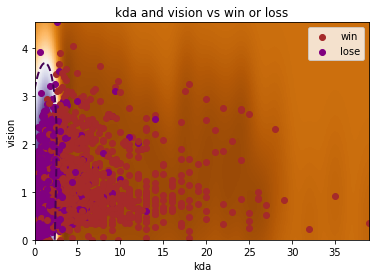

In [12]:
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")

w_checked = False
l_checked = False

for index, row in SVM_df.iterrows():
    if row['win'] == 0:  
        if not l_checked:
            plt.scatter(row['kda'], row['vision'], c='purple', label='lose')
            l_checked = True
        else:
            plt.scatter(row['kda'], row['vision'], c='purple')
    else:
        if not w_checked:
            plt.scatter(row['kda'], row['vision'], c='brown', label='win')
            w_checked = True
        else:
            plt.scatter(row['kda'], row['vision'], c='brown')

plt.legend()
plt.xticks()
plt.yticks()

plt.title('kda and vision vs win or loss')
plt.xlabel('kda')
plt.ylabel('vision')
plt.axis([0, SVM_df['kda'].max(), 0, SVM_df['vision'].max()])
plt.show()